# Previous models were trained on noisy datasets. 
A method was used to clean out mis-labelled data from these datasets. This notebook trains on cleaned data. 

In [1]:
description = "Train on 1700 present 3400 absent and balanced validation set. Does doubling the number of absent samples reduce the false positive rate?"

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, show_sample_from_df, clean_confidence_cats, get_recording_durations, plot_metrics_across_thresholds
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import glob
import sklearn
import ipywidgets as widgets

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"

# Log some hyperparameters

In [9]:
n_samples_per_class = 1700
one_output_neuron = True
random_seed = 42
learning_rate = 0.01
epochs=10

In [10]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [11]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

train_df.confidence_cat.value_counts()

confidence_cat
0     41658
3      1437
2       494
5       331
1       319
4        77
6        50
33        1
Name: count, dtype: int64

In [12]:
valid_df.value_counts()

target_absence  target_presence  confidence_cat
1.0             0.0              0                 9947
0.0             1.0              2                  360
                                 3                  357
                                 1                  296
                                 4                   28
                                 0                    2
Name: count, dtype: int64

In [13]:
train_df = clean_confidence_cats(train_df)
valid_df = clean_confidence_cats(valid_df)
train_df["target_absence"] = 1-train_df["target_presence"]
valid_df["target_absence"] = 1-valid_df["target_presence"]
train_df = train_df[["target_absence", "target_presence"]]
valid_df = valid_df[["target_absence", "target_presence"]]
train_df.value_counts(), valid_df.value_counts()

(target_absence  target_presence
 1.0             0.0                41770
 0.0             1.0                 1784
 Name: count, dtype: int64,
 target_absence  target_presence
 1.0             0.0                9947
 0.0             1.0                 387
 Name: count, dtype: int64)

# Remove invalid samples from invalid_samples.log

In [14]:
# read the contents of invalid_samples.log
with open("invalid_samples.log") as f:
    invalid_samples = f.readlines()
invalid_samples = [x.strip() for x in invalid_samples]
# convert to paths
invalid_samples = [Path(x) for x in invalid_samples]
# remove the invalid samples from the training set
train_df = train_df.drop(invalid_samples)


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_13300/743303743.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df = train_df.drop(invalid_samples)


In [15]:
invalid_samples

[PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')]

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [17]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
# assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
# assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

3ed8d8c88668fa05ffc408bd1253447e13b41b0dd5dd77926d3490686deecdc7 d54f471abbc0d72e038b376de5896e0efd679391e1d531dd1b1f2f259e813d3c


In [18]:
zero_len_recordings = [Path('../../data/raw/recordings/OSFL/recording-565606.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565607.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565618.flac')],
      

drop_df = train_df.loc[zero_len_recordings]
train_df.drop(drop_df.index, inplace=True)

In [19]:
train_df.target_presence.value_counts()

target_presence
0.0    41751
1.0     1783
Name: count, dtype: int64

# Resample

In [20]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=380,random_state=random_seed)
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    1700
 1.0    1700
 Name: count, dtype: int64,
 3400)

In [21]:
# Sample twice as many absent samples as present samples for this experiment
absent = train_df[train_df.target_presence == 0]
present = train_df[train_df.target_presence == 1]
absent = absent.sample(n = n_samples_per_class * 2, random_state=random_seed)
present = present.sample(n = n_samples_per_class, random_state=random_seed)
train_df = pd.concat([absent, present])
train_df.value_counts()

target_absence  target_presence
1.0             0.0                3400
0.0             1.0                1700
Name: count, dtype: int64

In [22]:
train_df.head()

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-316166... 3.0        6.0                  1.0   
../../data/raw/recordings/OSFL/recording-553577... 66.0       69.0                 1.0   
../../data/raw/recordings/OSFL/recording-293857... 13.5       16.5                 1.0   
../../data/raw/recordings/OSFL/recording-815868... 1.5        4.5                  1.0   
../../data/raw/recordings/OSFL/recording-104216... 22.5       25.5                 1.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-316166... 3.0        6.0                   0.0  
../../data/raw/recordings/OSFL/recording-553577... 66.0       69.0                  0.0  
../../data/raw/recordings/OSFL/recording-293857... 13.5       16.5                  0.0  
../../data/raw/recordings/OSFL/recording-815868... 1.5        4.5                   0.0  
../../data/raw/recordings/OSFL/recording-104216... 22.5       25.5                  0.0

In [23]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx]['target_presence']}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx
idx=0

Present label: 0.0
Last clip: 27.0


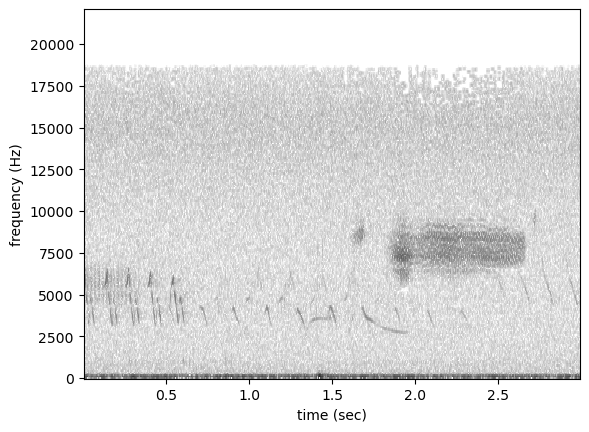

In [24]:
show_sample(train_df, idx)
idx += 1

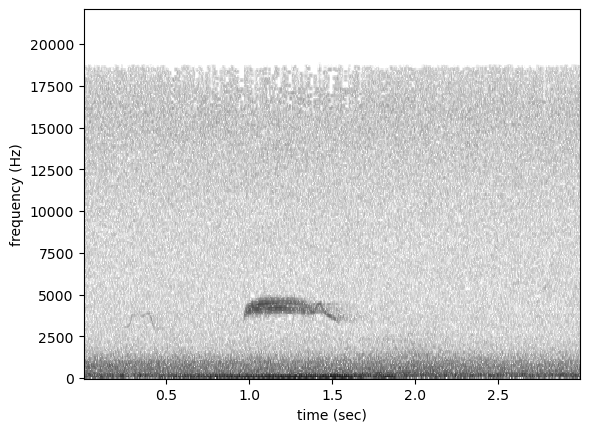

In [25]:
show_sample_from_df(train_df, 'absent')

# Shuffle the training data

In [26]:
train_df = train_df.sample(frac=1)
balanced_valid_df = balanced_valid_df.sample(frac=1)

# Drop the redundant absence class

In [27]:
train_df = train_df[["target_presence"]]
balanced_valid_df = balanced_valid_df[["target_presence"]]
train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

# Calculate recording durations for each recording in the training data
Some recordings might be corrupt and have zero samples. 

In [28]:
## Only need to do this if training fails due to zero length samples

# train_recording_durations = get_recording_durations(balanced_train_df)
# balanced_train_df['recording_duration'] = train_recording_durations
# balanced_train_df.loc[balanced_train_df['recording_duration'] < 3]

# Remove any additional invalid samples 
These may be printed during model training. 


In [29]:
def remove_files_from_df(df: pd.DataFrame, files: list):
    ''' 
    df must be a multi-indexed DataFrame with the first level being the file path.
    files is a list of string filepaths. 
    '''
    files = [Path(f) for f in files]
    df.drop(files, inplace=True)
    return df

In [30]:
short_samples = [("../../data/raw/recordings/OSFL/recording-293782.mp3"),
("../../data/raw/recordings/OSFL/recording-294264.mp3"),
("../../data/raw/recordings/OSFL/recording-292726.mp3"),
("../../data/raw/recordings/OSFL/recording-300271.mp3"),
("../../data/raw/recordings/OSFL/recording-296664.mp3"),]
train_df = remove_files_from_df(train_df, short_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_13300/3185280771.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(files, inplace=True)


In [31]:
len(train_df)

5079

In [32]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)
# Set this to 'True' if there are more than one possible target class (present, absent, other) and only one label can be true. Set it to 'False' if there is only one output node - this will allow a threshold to be set on the output score and will allow use of sigmoid instead of softmax on the output layer. 
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

# Inspect the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

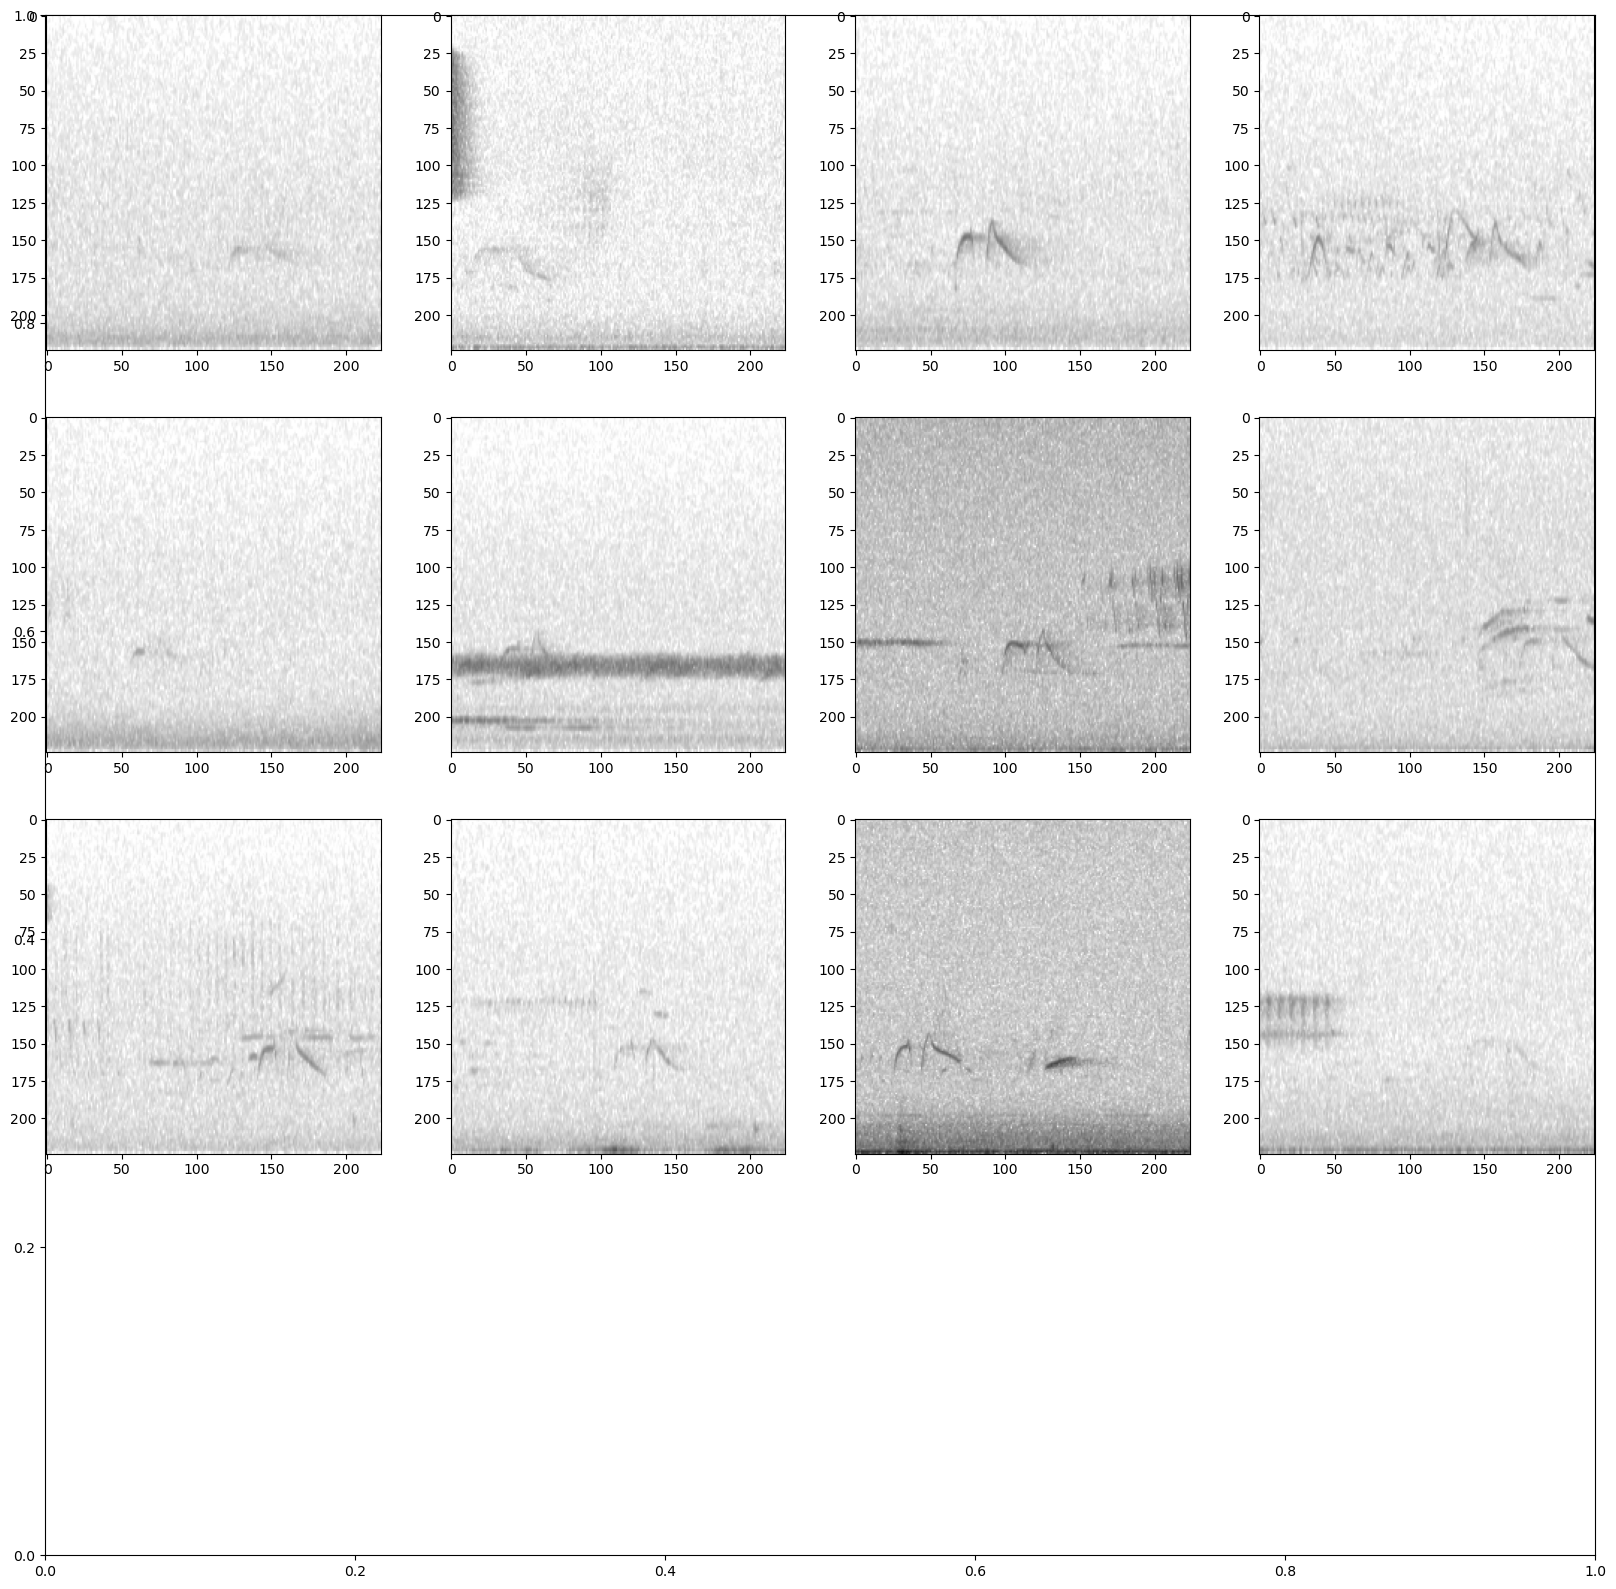

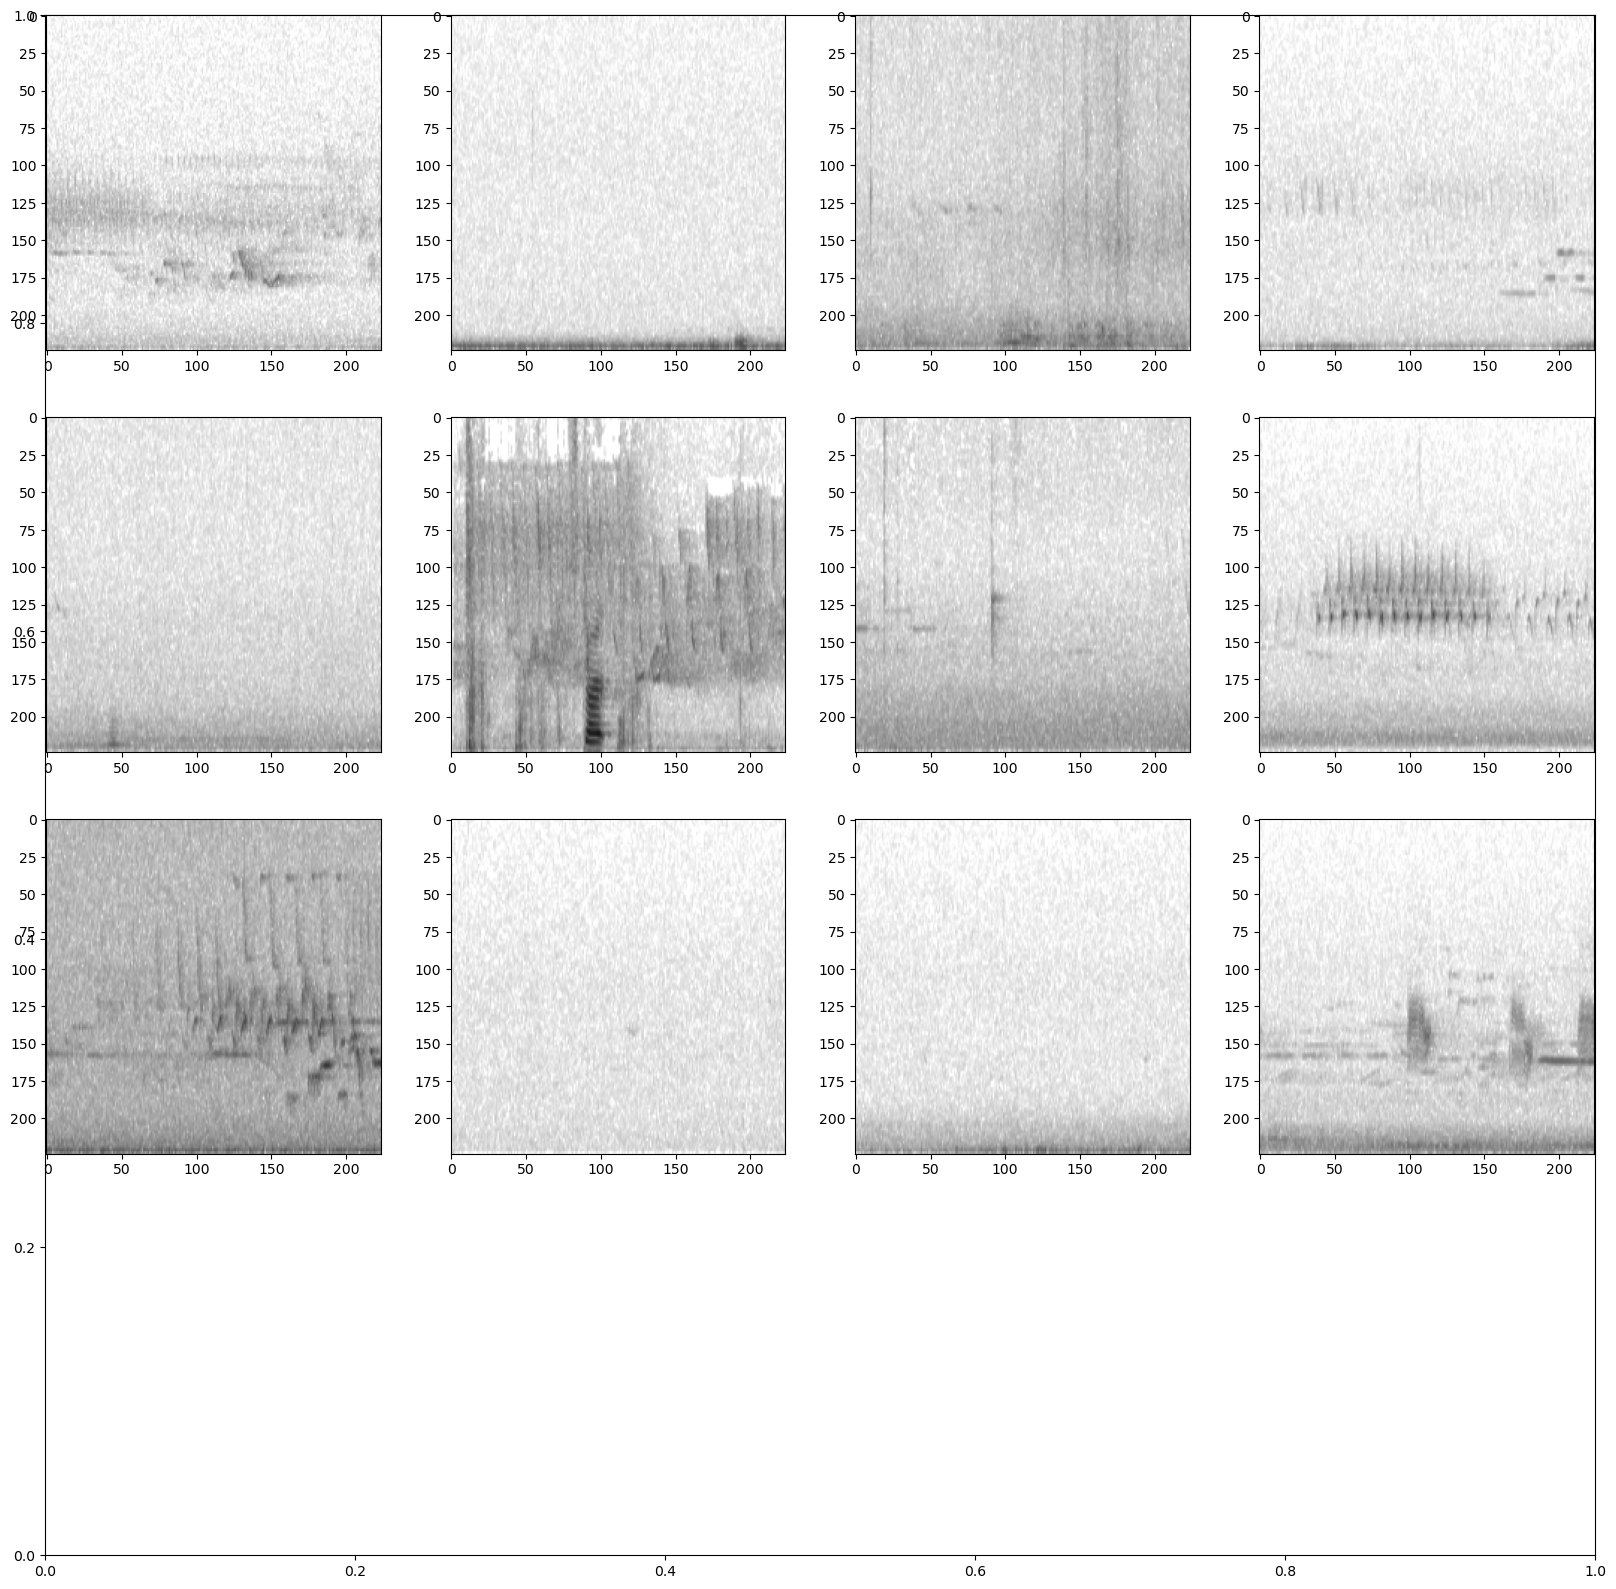

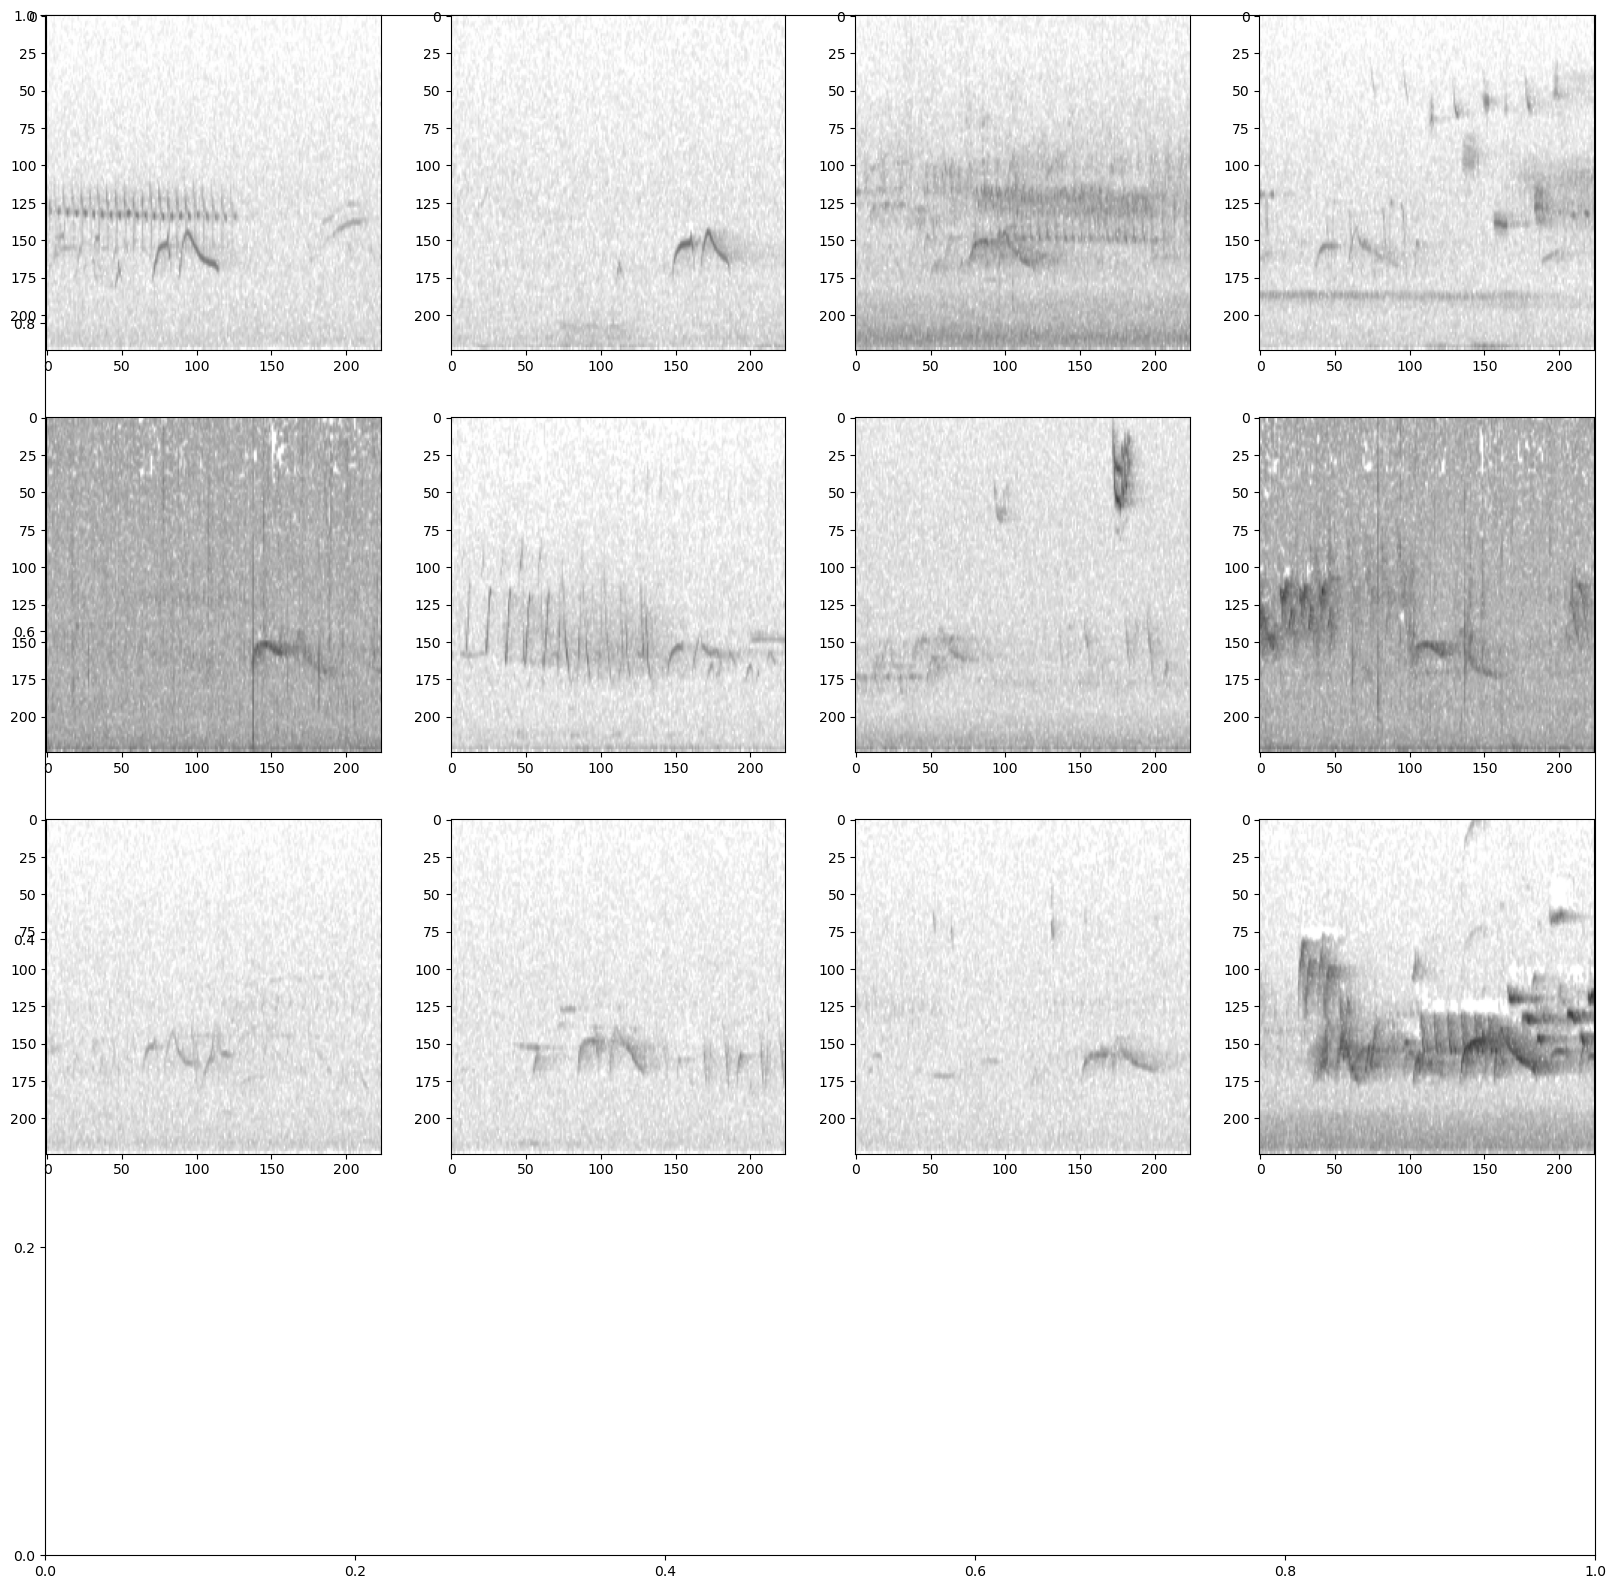

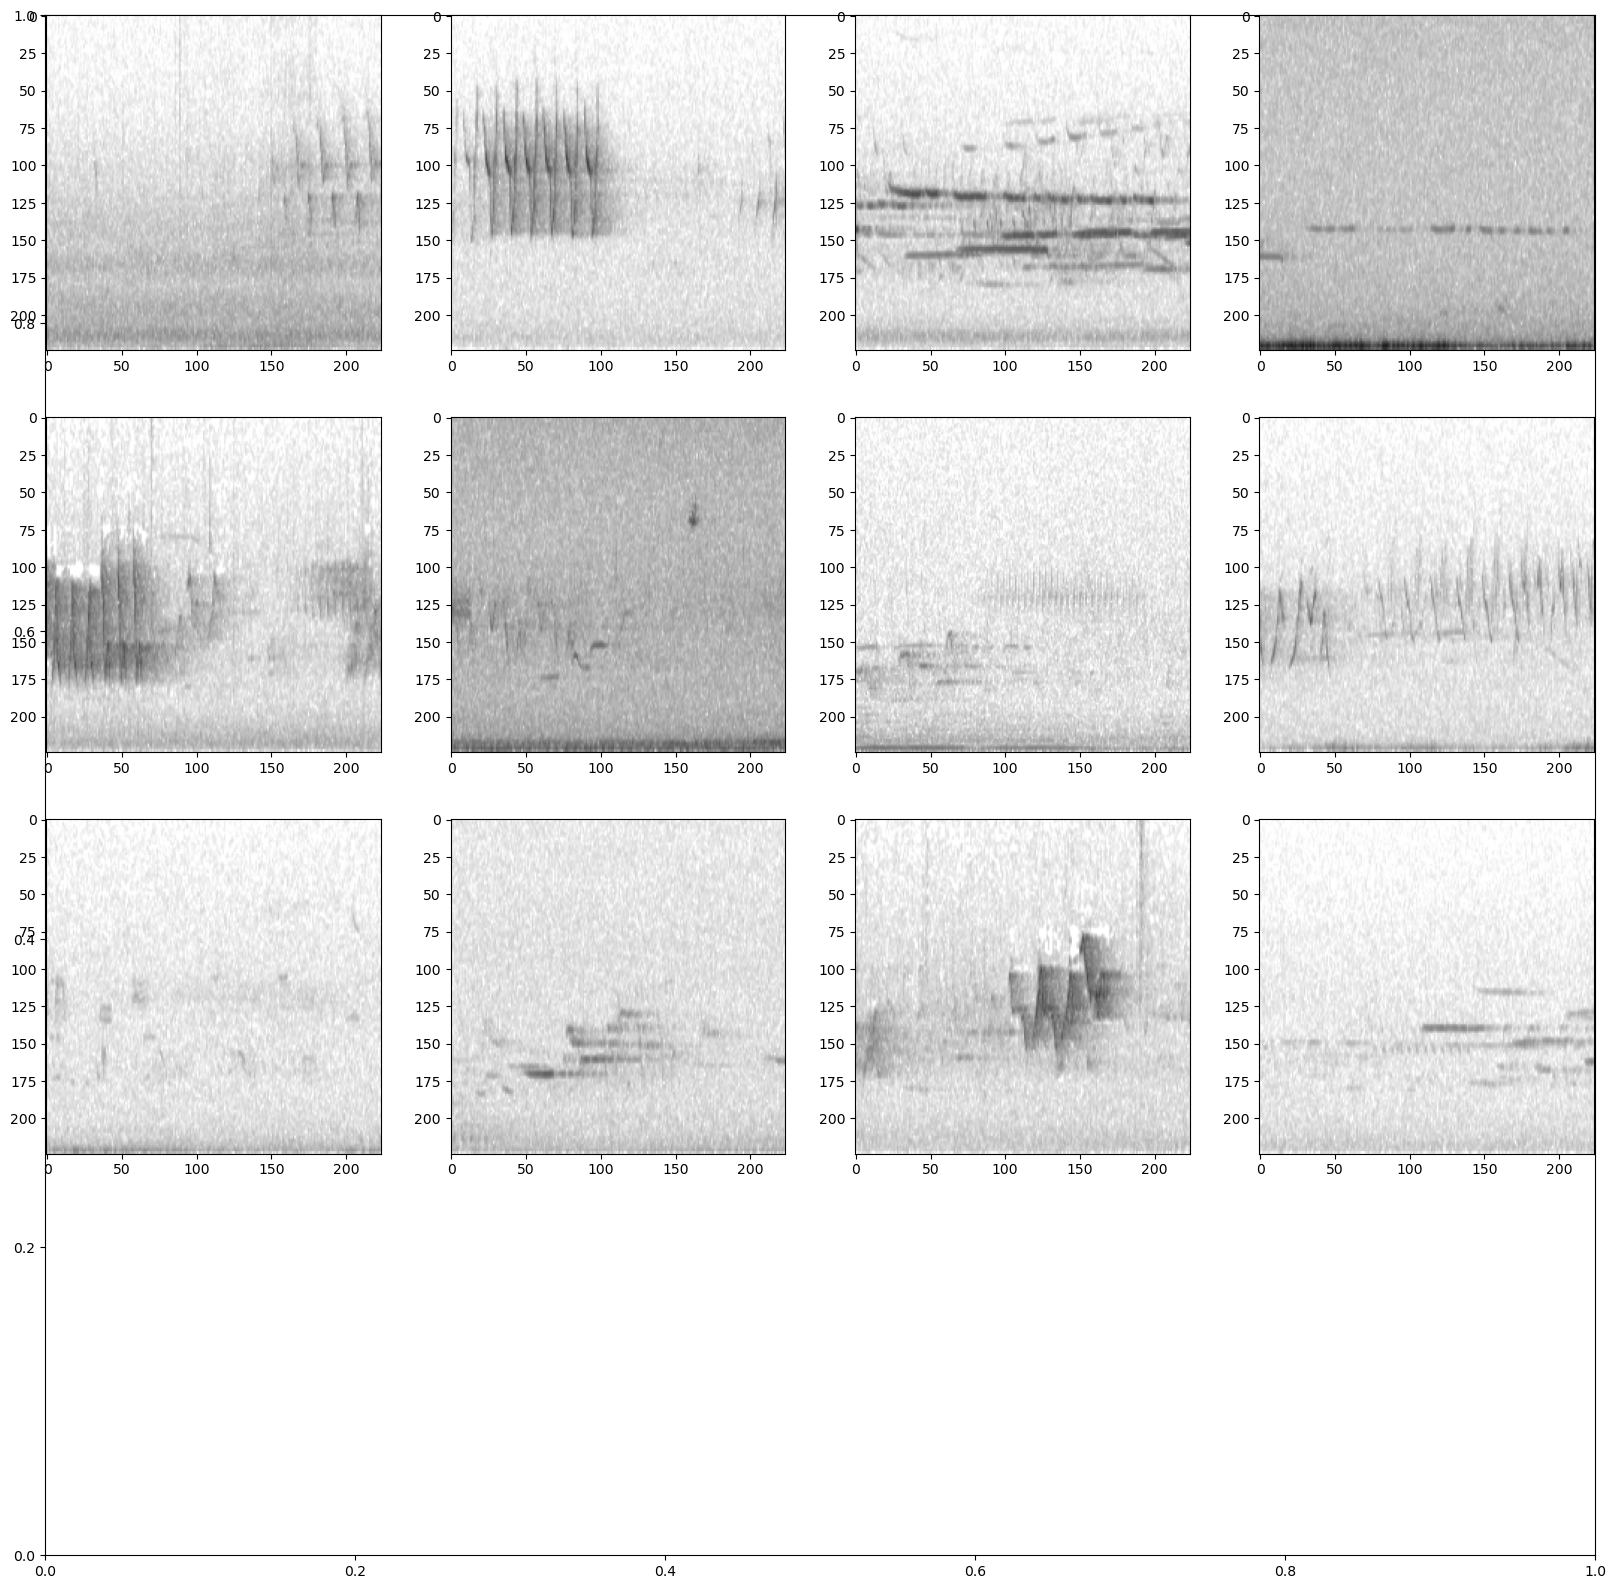

In [33]:
def inspect_input_samples(train_df, valid_df):
    present_t = train_df.loc[train_df.target_presence == 1]
    absent_t = train_df.loc[train_df.target_presence == 0]
    present_v = valid_df.loc[valid_df.target_presence == 1]
    absent_v = valid_df.loc[valid_df.target_presence == 0]

    # Generate a dataset with the samples we wish to inspect and the model's preprocessor
    for df in [present_t, absent_t, present_v, absent_v]:
        inspection_dataset = opso.AudioFileDataset(df.sample(12), model.preprocessor)
        inspection_dataset.bypass_augmentations = True

        samples = [sample.data for sample in inspection_dataset]
        _ = show_tensor_grid(samples, 4, invert=True)

inspect_input_samples(train_df, balanced_valid_df)


# Check for leakage

In [34]:
train_files = train_df.index.get_level_values("file")
valid_files = balanced_valid_df.index.get_level_values("file")
assert train_files.isin(valid_files).sum() == 0, "Train and validation sets have overlapping files"

In [35]:
model.optimizer_params['lr'] = learning_rate

In [36]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [37]:
class_list

['target_presence']

In [38]:
def show_sample_from_df(present=True, df = train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


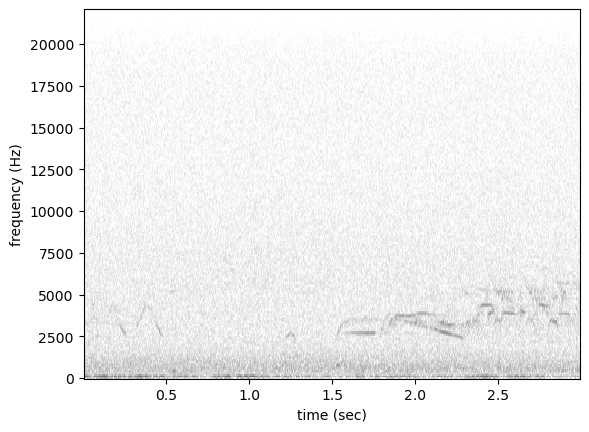

In [39]:
show_sample_from_df(present=True, df=train_df)


In [40]:
print(f'model.device is: {model.device}')

model.device is: mps


In [41]:
Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb')

In [42]:
%set_env WANDB_NOTEBOOK_NAME=({Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"})

env: WANDB_NOTEBOOK_NAME=(/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb)


# Weights and biases initialization

In [43]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find (/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb).
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [44]:
balanced_valid_df.value_counts()


target_presence
0.0                380
1.0                380
Name: count, dtype: int64

In [45]:
train_df.value_counts()

target_presence
0.0                3390
1.0                1689
Name: count, dtype: int64

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
model.train(
    train_df,
    balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, #4 parallelized cpu tasks for preprocessing, Reduce if training quits unexpectedly
    log_interval = 10,
    save_interval = 1,
    invalid_samples_log='./invalid_training_samples.log',
    raise_errors=True,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0 [batch 0/80, 0.00%] 
	DistLoss: 0.892
Metrics:
Epoch: 0 [batch 10/80, 12.50%] 
	DistLoss: 0.743
Metrics:
Epoch: 0 [batch 20/80, 25.00%] 
	DistLoss: 0.715
Metrics:
Epoch: 0 [batch 30/80, 37.50%] 
	DistLoss: 0.675
Metrics:
Epoch: 0 [batch 40/80, 50.00%] 
	DistLoss: 0.622
Metrics:
Epoch: 0 [batch 50/80, 62.50%] 
	DistLoss: 0.590
Metrics:
Epoch: 0 [batch 60/80, 75.00%] 
	DistLoss: 0.559
Metrics:
Epoch: 0 [batch 70/80, 87.50%] 
	DistLoss: 0.522
Metrics:
Metrics:
	MAP: 0.713

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.986

Training Epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 [batch 0/80, 0.00%] 
	DistLoss: 0.376
Metrics:
Epoch: 1 [batch 10/80, 12.50%] 
	DistLoss: 0.301
Metrics:
Epoch: 1 [batch 20/80, 25.00%] 
	DistLoss: 0.329
Metrics:
Epoch: 1 [batch 30/80, 37.50%] 
	DistLoss: 0.333
Metrics:
Epoch: 1 [batch 40/80, 50.00%] 
	DistLoss: 0.323
Metrics:
Epoch: 1 [batch 50/80, 62.50%] 
	DistLoss: 0.311
Metrics:
Epoch: 1 [batch 60/80, 75.00%] 
	DistLoss: 0.300
Metrics:
Epoch: 1 [batch 70/80, 87.50%] 
	DistLoss: 0.296
Metrics:
Metrics:
	MAP: 0.904

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.998

Training Epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2 [batch 0/80, 0.00%] 
	DistLoss: 0.214
Metrics:
Epoch: 2 [batch 10/80, 12.50%] 
	DistLoss: 0.224
Metrics:
Epoch: 2 [batch 20/80, 25.00%] 
	DistLoss: 0.233
Metrics:
Epoch: 2 [batch 30/80, 37.50%] 
	DistLoss: 0.272
Metrics:
Epoch: 2 [batch 40/80, 50.00%] 
	DistLoss: 0.261
Metrics:
Epoch: 2 [batch 50/80, 62.50%] 
	DistLoss: 0.251
Metrics:
Epoch: 2 [batch 60/80, 75.00%] 
	DistLoss: 0.251
Metrics:
Epoch: 2 [batch 70/80, 87.50%] 
	DistLoss: 0.248
Metrics:
Metrics:
	MAP: 0.932

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.994

Training Epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3 [batch 0/80, 0.00%] 
	DistLoss: 0.178
Metrics:
Epoch: 3 [batch 10/80, 12.50%] 
	DistLoss: 0.211
Metrics:
Epoch: 3 [batch 20/80, 25.00%] 
	DistLoss: 0.234
Metrics:
Epoch: 3 [batch 30/80, 37.50%] 
	DistLoss: 0.227
Metrics:
Epoch: 3 [batch 40/80, 50.00%] 
	DistLoss: 0.227
Metrics:
Epoch: 3 [batch 50/80, 62.50%] 
	DistLoss: 0.225
Metrics:
Epoch: 3 [batch 60/80, 75.00%] 
	DistLoss: 0.225
Metrics:
Epoch: 3 [batch 70/80, 87.50%] 
	DistLoss: 0.226
Metrics:
Metrics:
	MAP: 0.942

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.999

Training Epoch 4


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4 [batch 0/80, 0.00%] 
	DistLoss: 0.306
Metrics:
Epoch: 4 [batch 10/80, 12.50%] 
	DistLoss: 0.195
Metrics:
Epoch: 4 [batch 20/80, 25.00%] 
	DistLoss: 0.226
Metrics:
Epoch: 4 [batch 30/80, 37.50%] 
	DistLoss: 0.212
Metrics:
Epoch: 4 [batch 40/80, 50.00%] 
	DistLoss: 0.197
Metrics:
Epoch: 4 [batch 50/80, 62.50%] 
	DistLoss: 0.202
Metrics:
Epoch: 4 [batch 60/80, 75.00%] 
	DistLoss: 0.205
Metrics:
Epoch: 4 [batch 70/80, 87.50%] 
	DistLoss: 0.204
Metrics:
Metrics:
	MAP: 0.952

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Training Epoch 5


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5 [batch 0/80, 0.00%] 
	DistLoss: 0.340
Metrics:
Epoch: 5 [batch 10/80, 12.50%] 
	DistLoss: 0.223
Metrics:
Epoch: 5 [batch 20/80, 25.00%] 
	DistLoss: 0.215
Metrics:
Epoch: 5 [batch 30/80, 37.50%] 
	DistLoss: 0.221
Metrics:
Epoch: 5 [batch 40/80, 50.00%] 
	DistLoss: 0.223
Metrics:
Epoch: 5 [batch 50/80, 62.50%] 
	DistLoss: 0.222
Metrics:
Epoch: 5 [batch 60/80, 75.00%] 
	DistLoss: 0.220
Metrics:
Epoch: 5 [batch 70/80, 87.50%] 
	DistLoss: 0.221
Metrics:
Metrics:
	MAP: 0.944

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.998

Training Epoch 6


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6 [batch 0/80, 0.00%] 
	DistLoss: 0.197
Metrics:
Epoch: 6 [batch 10/80, 12.50%] 
	DistLoss: 0.190
Metrics:
Epoch: 6 [batch 20/80, 25.00%] 
	DistLoss: 0.196
Metrics:
Epoch: 6 [batch 30/80, 37.50%] 
	DistLoss: 0.187
Metrics:
Epoch: 6 [batch 40/80, 50.00%] 
	DistLoss: 0.181
Metrics:
Epoch: 6 [batch 50/80, 62.50%] 
	DistLoss: 0.191
Metrics:
Epoch: 6 [batch 60/80, 75.00%] 
	DistLoss: 0.199
Metrics:
Epoch: 6 [batch 70/80, 87.50%] 
	DistLoss: 0.196
Metrics:
Metrics:
	MAP: 0.955

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.999

Training Epoch 7


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7 [batch 0/80, 0.00%] 
	DistLoss: 0.358
Metrics:
Epoch: 7 [batch 10/80, 12.50%] 
	DistLoss: 0.205
Metrics:
Epoch: 7 [batch 20/80, 25.00%] 
	DistLoss: 0.185
Metrics:
Epoch: 7 [batch 30/80, 37.50%] 
	DistLoss: 0.184
Metrics:
Epoch: 7 [batch 40/80, 50.00%] 
	DistLoss: 0.185
Metrics:
Epoch: 7 [batch 50/80, 62.50%] 
	DistLoss: 0.186
Metrics:
Epoch: 7 [batch 60/80, 75.00%] 
	DistLoss: 0.187
Metrics:
Epoch: 7 [batch 70/80, 87.50%] 
	DistLoss: 0.181
Metrics:
Metrics:
	MAP: 0.961

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.998

Training Epoch 8


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8 [batch 0/80, 0.00%] 
	DistLoss: 0.048
Metrics:
Epoch: 8 [batch 10/80, 12.50%] 
	DistLoss: 0.132
Metrics:
Epoch: 8 [batch 20/80, 25.00%] 
	DistLoss: 0.146
Metrics:
Epoch: 8 [batch 30/80, 37.50%] 
	DistLoss: 0.152
Metrics:
Epoch: 8 [batch 40/80, 50.00%] 
	DistLoss: 0.157
Metrics:
Epoch: 8 [batch 50/80, 62.50%] 
	DistLoss: 0.164
Metrics:
Epoch: 8 [batch 60/80, 75.00%] 
	DistLoss: 0.167
Metrics:
Epoch: 8 [batch 70/80, 87.50%] 
	DistLoss: 0.170
Metrics:
Metrics:
	MAP: 0.965

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.999

Training Epoch 9


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9 [batch 0/80, 0.00%] 
	DistLoss: 0.057
Metrics:
Epoch: 9 [batch 10/80, 12.50%] 
	DistLoss: 0.198
Metrics:
Epoch: 9 [batch 20/80, 25.00%] 
	DistLoss: 0.183
Metrics:
Epoch: 9 [batch 30/80, 37.50%] 
	DistLoss: 0.180
Metrics:
Epoch: 9 [batch 40/80, 50.00%] 
	DistLoss: 0.175
Metrics:
Epoch: 9 [batch 50/80, 62.50%] 
	DistLoss: 0.167
Metrics:
Epoch: 9 [batch 60/80, 75.00%] 
	DistLoss: 0.177
Metrics:
Epoch: 9 [batch 70/80, 87.50%] 
	DistLoss: 0.177
Metrics:
Metrics:
	MAP: 0.962

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.998

Best Model Appears at Epoch 8 with Validation score 0.999.


In [71]:
# Load the checkpoint from the best epoch
model = opso.load_model("best.model")

# Show metrics per epoch

In [72]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.9903739612188366,
   'avg_precision': 0.9860746693759499,
   'precision': 0.9707446808510638,
   'recall': 0.9605263157894737,
   'f1': 0.9656084656084656,
   'support': 380},
  'precision': 0.9658410904255319,
  'recall': 0.9657894736842105,
  'f1': 0.9657885259979501,
  'jaccard': 0.9338405257535045,
  'hamming_loss': 0.034210526315789476,
  'map': 0.9860746693759499,
  'au_roc': 0.9903739612188366},
 1: {'target_presence': {'au_roc': 0.9975484764542937,
   'avg_precision': 0.9975748838407618,
   'precision': 0.9419191919191919,
   'recall': 0.9815789473684211,
   'f1': 0.961340206185567,
   'support': 380},
  'precision': 0.9613442113442113,
  'recall': 0.9605263157894737,
  'f1': 0.9605088127702028,
  'jaccard': 0.9240194664050627,
  'hamming_loss': 0.039473684210526314,
  'map': 0.9975748838407618,
  'au_roc': 0.9975484764542937},
 2: {'target_presence': {'au_roc': 0.9947091412742383,
   'avg_precision': 0.9938304833737418,
   'precision': 0.99

In [73]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.7843214204002649,
   'avg_precision': 0.7129550559995325,
   'precision': 0.7682808716707021,
   'recall': 0.9359882005899705,
   'f1': 0.8438829787234041,
   'support': 3390},
  'precision': 0.7698095612305038,
  'recall': 0.6846903702772232,
  'f1': 0.6994244309841433,
  'jaccard': 0.5569895268558529,
  'hamming_loss': 0.23114786375270724,
  'map': 0.7129550559995325,
  'au_roc': 0.7843214204002649},
 1: {'target_presence': {'au_roc': 0.9289677612034142,
   'avg_precision': 0.9035354020690401,
   'precision': 0.8757349011223945,
   'recall': 0.9666666666666667,
   'f1': 0.918956814357824,
   'support': 3390},
  'precision': 0.8956086622291105,
  'recall': 0.8456779159265837,
  'f1': 0.8639727892013839,
  'jaccard': 0.7646550669309644,
  'hamming_loss': 0.1138019295136838,
  'map': 0.9035354020690401,
  'au_roc': 0.9289677612034142},
 2: {'target_presence': {'au_roc': 0.9512525084225363,
   'avg_precision': 0.9323189683580811,
   'precision': 0.893

# Plot a confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

In [74]:
scores_df = model.predict(balanced_valid_df, activation_layer='sigmoid')

  0%|          | 0/760 [00:00<?, ?it/s]

In [75]:
def get_binary_predictions(target_df, model_predictions_df, threshold=0.5):
    '''
    Calculate the binary predictions needed for confusion matrix and other metrics. 
    target_df: DataFrame with labels in the target_presence column
    model_predictions_df: DataFrame with model predictions in target_presence column
    '''
    targets = target_df.target_presence.values
    scores = model_predictions_df.target_presence.values
    binary_preds = (scores > threshold).astype(float)
    return binary_preds, targets, scores


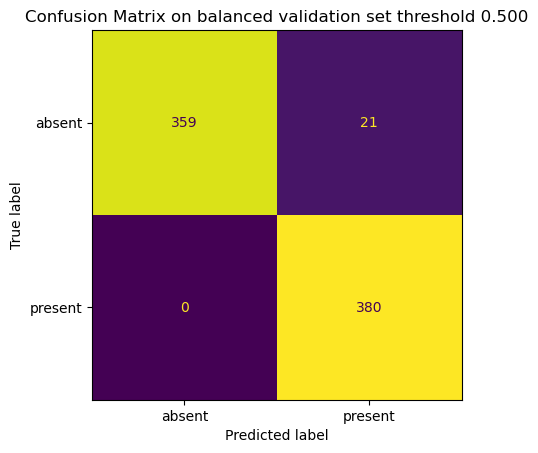

In [76]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(balanced_valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion Matrix on balanced validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Look at the metrics across thresholds
for the balanced validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


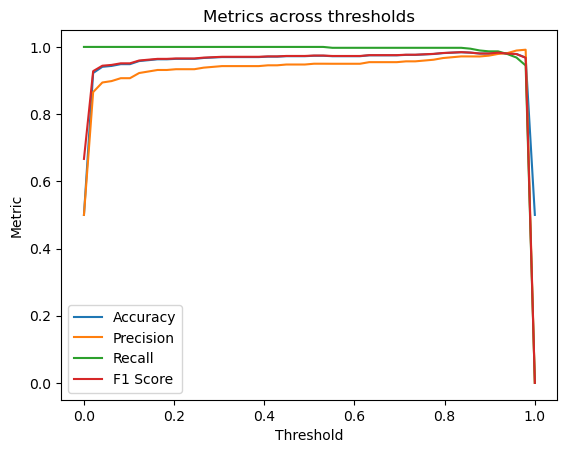

In [77]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [78]:
cm

array([[359,  21],
       [  0, 380]])

In [79]:
# log confusion matrix to wandb as a table
wandb.log({"validation.confusion_matrix": cm})


Error: You must call wandb.init() before wandb.log()

In [56]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Make predictions and plot confusion matrix on the full validation set
During training we only looked at a subset of the validation set values. 

In [80]:
scores_df = model.predict(valid_df, activation_layer='sigmoid')


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10334 [00:00<?, ?it/s]

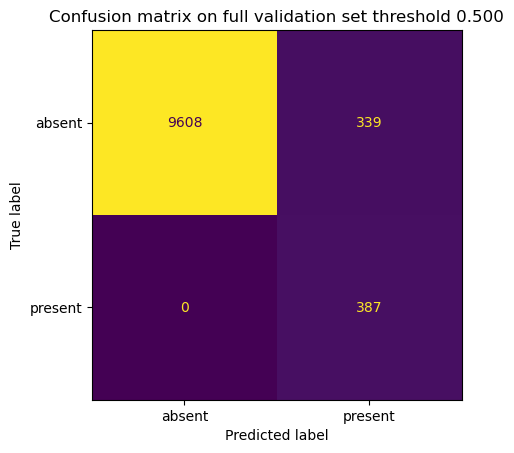

In [84]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Interactive confusion matrix


In [85]:

def show_cm(threshold):
    # Calculate the confusion matrix
    binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
    cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.4f}")
    cm_display.plot(ax=ax, colorbar=False)

from ipywidgets import interact
interact(show_cm, threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.0001, value=0.5))
# show_cm(0.5)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

<function __main__.show_cm(threshold)>

# Look at the metrics across thresholds
for the full validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


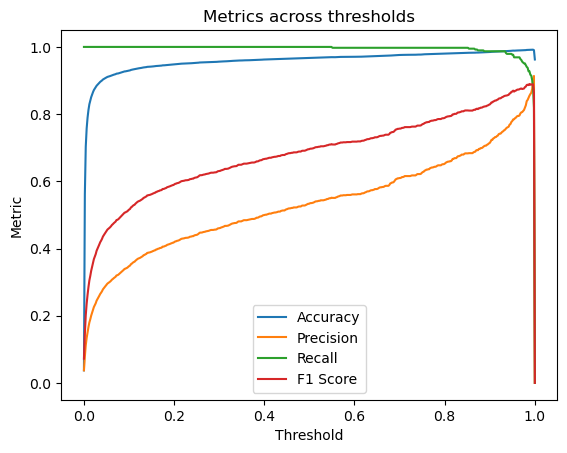

Error: You must call wandb.init() before wandb.log()

In [88]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

log_single_metric(accuracies, "accuracy_full_set")
log_single_metric(precisions, "precision_full_set")
log_single_metric(recalls, "recall_full_set")
log_single_metric(f1s, "f1_full_set")

# Result: 
Training on 1700 from each class produces a model with high precision and recall. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check. There you can load a pretrained model, make predictions on the validation set, and look at predictions in order of highest error for each class. 

# Save the best model to disk


In [89]:
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"{wandb.run.name}{}")

AttributeError: 'NoneType' object has no attribute 'name'

In [61]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore
